# Introduction & Objective

<font color='midnightblue'>The goal of this notebook is to conduct extensive Exploratory Data Analysis on 450k+ TTC Bus Delay events using the [TTC Bus Delay Data](https://open.toronto.ca/dataset/ttc-bus-delay-data/) provided by the City of Toronto Open Data Portal. The data used for this notebook has already been preprocessed through the "preprocessing.ipynb" notebook and now resides in the "intermediate" sub-directory of bus data. The feature engineering and final data for Machine Learning will be exported to the "final" sub-directory of bus data.</font>

<font color='midnightblue'> The EDA Will be done with the following objectives:
- Understanding the features and data in different granuity.
- Learning of what questions TTC need to ask to improve its services.
- Discovery of transit problems which can be solved with Data Science and Machine Learning models. </font>

<font color='midnightblue'> With these objectives in mind, the flow of the EDA will involve deep investigation of the variables in the dataset. 
- We will start with univariate analysis of each feature by itself (Time-Series, Numeric and Categorical features are seperatedly analyzed).
- Then we will take a look at interactions between these variables with multi-variate analysis.
- Finally, we will end with recommending ways in which we can analyze features which are more resistant to visualizations. </font>

# Import Libraries, Loading intermediate data

In [ ]:
# Import libraries
import os, sys
import json
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import files from google drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
# Load paths, replace with your own path if you're developing locally
master_path = '/content/gdrive/My Drive/ColabNtb/ttc_delay'
with open(os.path.join(master_path, 'data/paths.json'), 'r') as json_file:
  paths = json.load(json_file)

Mounted at /content/gdrive


In [ ]:
# Import custom util scripts for EDA
sys.path.append(paths['src'])
from utils import understand_dataframe, plot_multiple_hist, plot_multiple_bar, plot_multiple_timeseries, plot_multiple_timeseries_sum, get_association, slice_and_dice

In [ ]:
# Load intermediate data
df_bus = pd.read_csv(os.path.join(paths['intermediate/bus'], 'bus.csv'))
df_bus = df_bus.rename(columns={df_bus.columns[0]: "id" })

In [ ]:
# Read the meta data (if needed)
# for row in pd.read_excel(os.path.join(paths['raw/bus'], 'ttc-bus-delay-data-readme.xlsx')).iterrows():
#   print(row[1].values[0])
#   print(row[1].values[1])
#   print('\n')

# Uni-variate Data Analysis

In [ ]:
# View possible variables to investigate
understand_dataframe(df_bus)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479404 entries, 0 to 479403
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 479404 non-null  int64  
 1   Route              479404 non-null  int64  
 2   Day                479404 non-null  object 
 3   Location           478594 non-null  object 
 4   Incident           478469 non-null  object 
 5   Delay              479404 non-null  float64
 6   Gap                479404 non-null  float64
 7   Direction          479404 non-null  object 
 8   Vehicle            479404 non-null  int64  
 9   datetime           479404 non-null  object 
 10  year               479404 non-null  int64  
 11  month              479404 non-null  int64  
 12  dayofweek          479404 non-null  int64  
 13  hour               479404 non-null  int64  
 14  date               479404 non-null  object 
 15  Location_combined  478567 non-null  object 
dtypes:

<font color='midnightblue'>The types of data we encounter are time-series, numeric, categorical. We can make a prelimilary division between continuous and discrete variables to visualize. There are certain categorical variables with a large number of categories (Location_combined, Vehicle) we will leave for later.
- Time Series: datetime, month, year, dayofweek
- Continuous: Delay, Gap
- Discrete: Incident, Direction, year, month, dayofweek, hour </font>

In [ ]:
# Create a dataframe with all the needed column, along with the list of numeric and categorical variables
num_cols = ['Delay', 'Gap']
cat_cols = ['Incident', 'Direction', 'year', 'month', 'dayofweek', 'hour', 'id'] # id is a dummy variable
time_cols = ['datetime']
df = df_bus[num_cols + cat_cols + time_cols]

In [ ]:
# Convert columns to relevant data types
for feat in time_cols:
  df[feat] = pd.to_datetime(df[feat])
for feat in num_cols:
  df[feat] = df[feat].astype('int')
for feat in cat_cols:
  df[feat] = df[feat].astype('category')

## Time Series Analysis

<font color='midnightblue'>First, we want to see the big picture with number of delay incidents over time in different granuality (yearly, monthly, daily). This will help us get a sense of how the data story.</font>

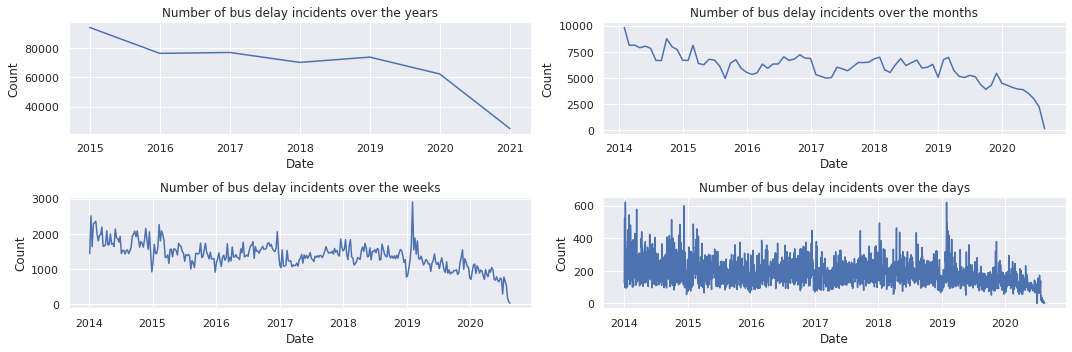

In [ ]:
# Use our custom functions to plot multiple granuity of time series in terms of incident count
plot_multiple_timeseries(df.set_index('datetime').id, ['year', 'month', 'week', 'day'], 2, 2)

<font color='midnightblue'>A few thing to note here:
- Over the years, the number of incidents has gone down in general (As the transit system grows and more routes are added, there will be more delay incidents in general so a drop in the overall incident count shows that possibly measures are being taken to reduce delay). As the data only continues until August 2020, we should not interpret the drop at the end to be something significant.
- The monthly granuity shows there is cyclic pattern (seasonality) in the time series.
- The weekly granuity shows a few possible daily outliers (a week at the beginning of 2019 for example). But overall, the trend seems to have no anomaly.</font>

<font color='midnightblue'>At this point, we've managed to get a sense of number of incident. Let's look at it in another perspective to see whether the story changes if total delay minutes are counted instead of number of incident.
</font>

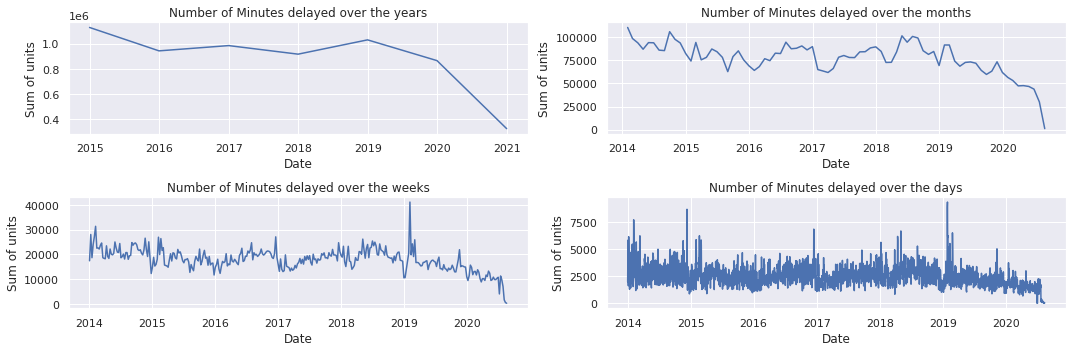

In [ ]:
# Use our custom functions to plot multiple granuity of time series in terms of total minutes of delay
plot_multiple_timeseries_sum(df.set_index('datetime').Delay, ['year', 'month', 'week', 'day'], 2, 2)

<font color='midnightblue'>Looks like when we look at the total delay minutes, the trend has gone down only slightly over the years and even achieved a local peak in 2019. Along with the previous visualization, we can see that as more routes are added, the efforts to reduce delay incidents are counteract by possibly the higher number of routes creating more traffic jam and delay per route. We can check the number of routes being delayed every year for more evidence for this hypothesis.
</font>

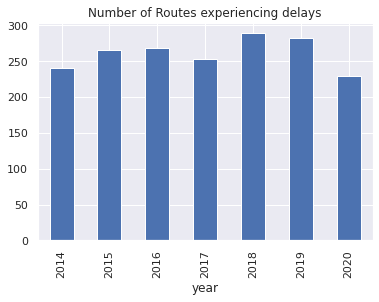

In [ ]:
# Plot the number of routes experiencing delay by year
df_bus.groupby('year')['Route'].nunique().plot(kind='bar', title='Number of Routes experiencing delays')
plt.show()

<font color='midnightblue'>We can see that yes, there is a higher number of routes experiencing delays in later years.
</font>

## Numeric data visualization

<font color='midnightblue'>Next, we can investigate the continuous variables (delay time of delay incidents). The two variables we will look at are Delay (the minutes the said bus is delayed) and Gap (the minute gap between one bus to another due to the delay incident). </font>

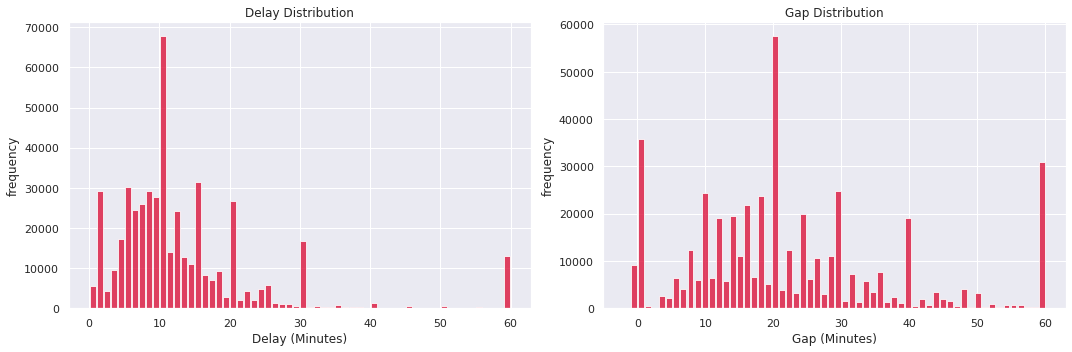

In [ ]:
# Plot histograms of our two numerical variables
plot_multiple_hist(df=df,
                   unit_map_dict={"Delay": "Minutes", "Gap": "Minutes"},
                   num_cols=num_cols,
                   rows=1, cols=2,
                   bins=60)

<font color='midnightblue'> A few things of note:
- Most delays to a given bus are between 0-30 minutes. So you'd expect your bus to come even if it is late. However, there are some 60+ minutes delay which may be outliers.
- It is typical for gaps to be twice the delay (evidence by looking at samples and the fact that even minute gaps are much more prevalent than odd minute gaps). This is likely operators adjust the schedule of following buses to abide by the regular timing despite the delay.</font>

In [ ]:
print(f'The percentage of even-minute gaps is: {round(sum(df[df.Gap < 60].Gap % 2 == 0) / len(df[df.Gap < 60]), 3) * 100}%')

The percentage of even-minute gaps is: 74.1%


<font color='midnightblue'>This shows that in the case of a delay, up to three fourth of all buses time schedule are adjusted to abide by regular timing of the said bus route. This assumption can also be checked by speaking to bus operators.

Now, we could also bin the delay timing to help us understand the severity of delays better. </font>

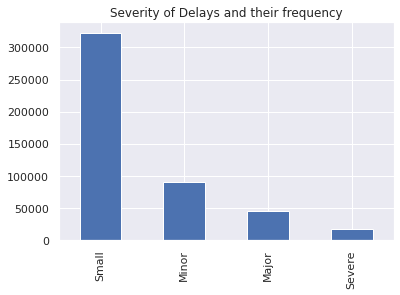

In [ ]:
# Bins are created just by my own opinion of what is a minor or major delay:
# Minor delay: Acceptable delays that don't matter a lot.
# Small delay: Delays which can start to create issues for riders.
# Major delay: Delays which are problematic and can cause people to be late for important engagements.
# Severe delay: Unacceptable delays that most people would not wait for.
bins = [0, 5, 20, 40, 60]
df['Severity'] = pd.cut(df_bus.Delay, bins, labels=['Minor', 'Small', 'Major', 'Severe'])
df['Severity'].value_counts().plot(kind='bar', title='Severity of Delays and their frequency')
plt.show()

<font color='midnightblue'> Expectedly, most delays are small or minor. However, there are still significant proportion of delays which are not simply inconvenient for riders. Two important KPIs here to justify a usecase for real-time ML are: The percentages of major and severe delays AND the percentage of delays which are inconvenient (small) out of all the acceptable delays.</font>

In [ ]:
print(f'Percentage of unacceptable delays out of all delays are: {round(sum(df.Severity.value_counts(normalize=True)[2:]), 3) * 100}%')
print(f'Percentage of inconvenient delays out of all acceptable delays are: {round(df.Severity.value_counts(normalize=True)[0] / (df.Severity.value_counts(normalize=True)[0] + df.Severity.value_counts(normalize=True)[1])*100, 1)}%')

Percentage of unacceptable delays out of all delays are: 12.8%
Percentage of inconvenient delays out of all acceptable delays are: 78.1%


## Categorical data visualization

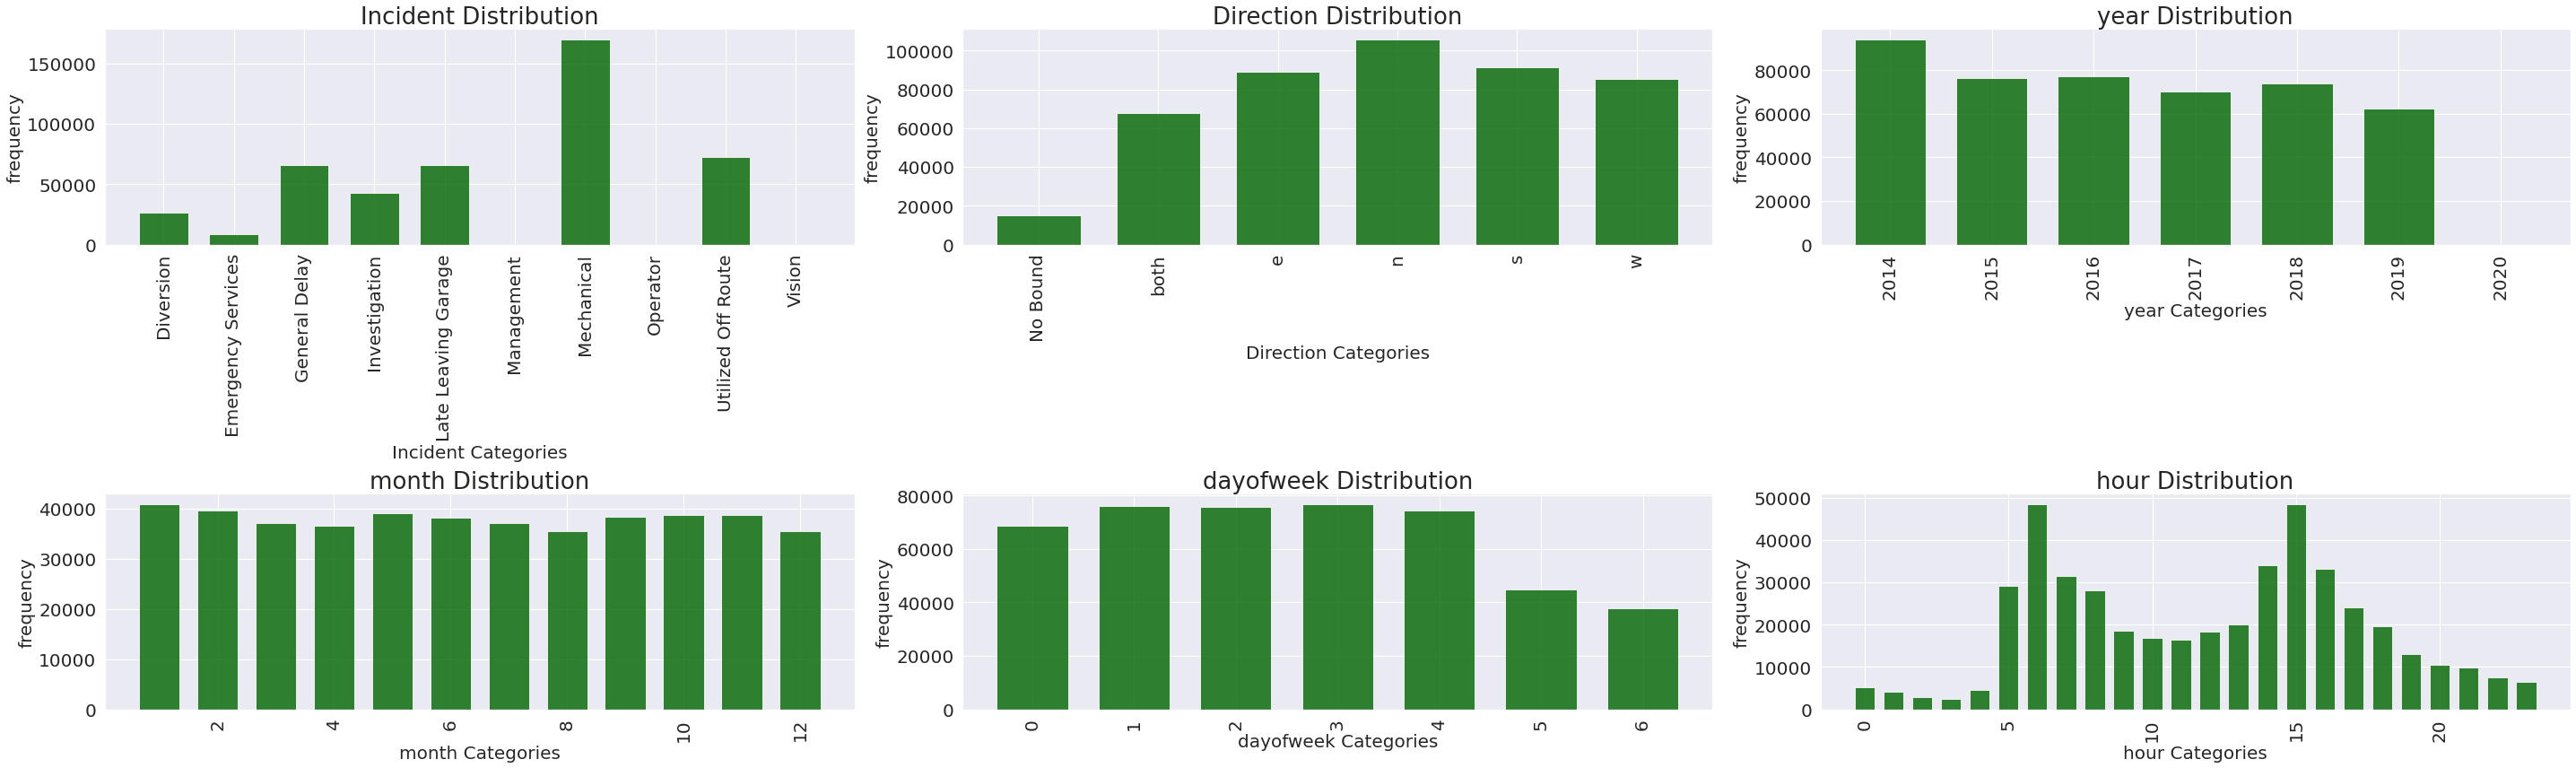

In [ ]:
# Plot histogram of our categorical variables. We remove 2020 delays because data is available only until Aug 2020.
plot_multiple_bar(df=df[df.year != 2020],
                  cat_cols=cat_cols,
                  rows=2, cols=3,
                  params = {'legend.fontsize': 20,
                            'axes.labelsize': 20,
                            'axes.titlesize':26,
                            'xtick.labelsize':20,
                            'ytick.labelsize':20})

<font color='midnightblue'> A few things to note:
- Incidents: Significant causes of delay are Mechanical, Tardiness and Utilized Off Route. These variables are not very self explanatory and further investigation into what they mean may be important.
- Direction: The order of most delay incidents are N > S > E > W, though not by a great margin. This makes sense as the N - S direction are greater stretch in Toronto. A prior probability of general route direction needed to understand whether any direction is particularly incident-heavy. We can also slice and dice in multi-variate analysis to understand the distribution better.
- Year: As analyzed in time-series analysis, the number of incident has fluctuated over the years but there is a clear decreasing trend.  
- Month: Delay peaks in January/ February (snow months) and Mid-Summer, Mid-Autumn.
- Dayofweek: Delay peaks in the middle of the week (traffic as people get to work) but a significant number of delays still happens on Weekend (day 5 and 6).
- Hour: Within a day, hour distribution looks bi-modal, with delay incidents peaking around 6 A.M and 3 P.M. Both peaks are a little early (off by 1-2 hours) from the usual commuting to work/commuting home hours so datetime timezone data should be checked.  </font>

# Multi-variate Data Analysis

<font color='midnightblue'>Looking into single variables has allowed us to understand better the data. However, variables are often inter-related. Here we will use Correlation plots, scatterplots and slice and dice to gain more understanding of the data.</font>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479404 entries, 0 to 479403
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Delay      479404 non-null  int64         
 1   Gap        479404 non-null  int64         
 2   Incident   478469 non-null  category      
 3   Direction  479404 non-null  category      
 4   year       479404 non-null  category      
 5   month      479404 non-null  category      
 6   dayofweek  479404 non-null  category      
 7   hour       479404 non-null  category      
 8   id         479404 non-null  category      
 9   datetime   479404 non-null  datetime64[ns]
 10  Severity   473974 non-null  category      
dtypes: category(8), datetime64[ns](1), int64(2)
memory usage: 39.7 MB


## Correlation plot

<font color='midnightblue'>We can plot simple correlations to see which variables tend to go together. A few things should be noted here:
- Our two numeric variables should be highly correlated as we learnt that up to 75% of Gaps are simple twice of Delays. A simple check will do.
- Since most of our variables are categorical, we will use Cramér's V measure of categorical-to-categorical association to run a heat map on association and find pairs of related features.
- Although we have binned Delay into Severity. We might consider using Correlation Ratio to find intraclass correlation between numeric and categorical data.</font>

In [ ]:
# Get a dataframe of all categorical data
cat_cols = cat_cols[:-1]
cat_cols.append('Severity')
df_cat = df[cat_cols]
print(f'Rows without Nan are {round(len(df_cat.dropna())/len(df_cat), 3)*100}% of the dataset')

# Since rows with nans consist of only 0.3% of the dataset, we will remove them for the sake of creating an association graph
df_cat = df_cat.dropna()

Rows without Nan are 98.7% of the dataset


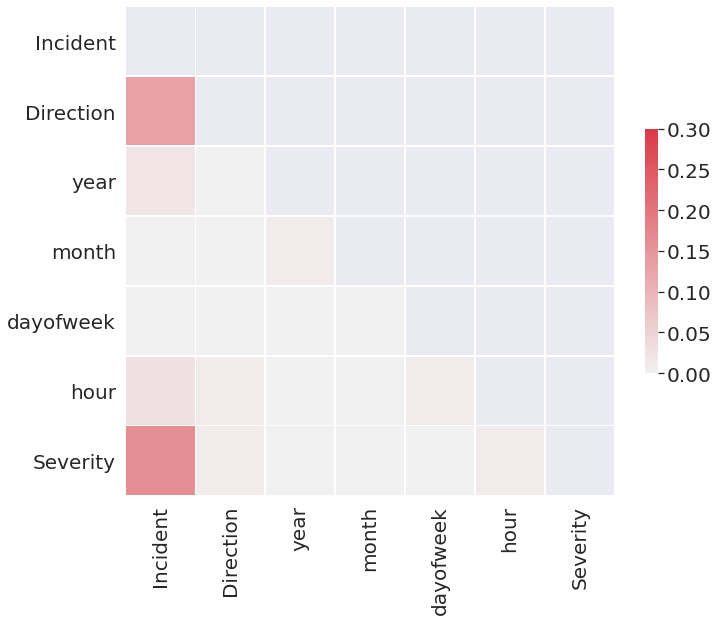

In [ ]:
# Get the correlation matrix and draw the association graph using our custom function
corr = get_association(df_cat)

<font color='midnightblue'>Most categorical pairs don't have strong association. However, there are two substantive relationships (> 0.1) between:
- Type of Incident and the Direction of bus movement. This suggest that certain incidents are more likely to occur on some particular directions.
- Type of Incident and the Severity of Incident. This suggest that certain types of incidents might cause more delays then others.</font>

<font color='midnightblue'>We will explore these relationships on the slice and dice section.</font>

## Pairplot

<font color='midnightblue'>Next, we will have a glimpse at the Scatterplot to understand correlation among numeric variables</font>

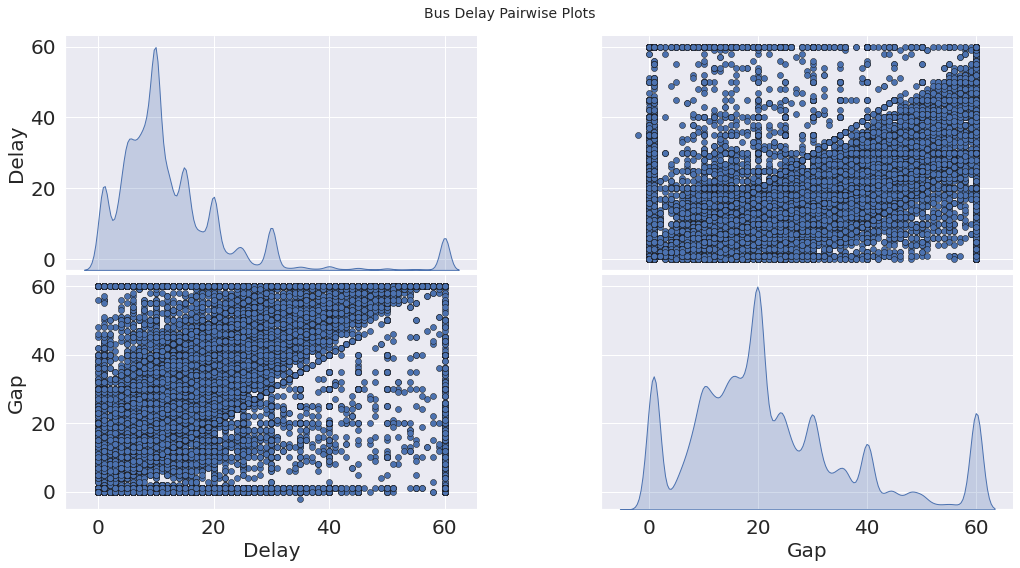

In [ ]:
# Construct Pairplots for our numerical variables 
pp = sns.pairplot(df[num_cols], size=4, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Bus Delay Pairwise Plots', fontsize=14)

<font color='midnightblue'>We can see a clear positive relationship between Delay and Gap</font>

## Slice and dice

<font color='midnightblue'>In this section, we will slice and dice the related variables and any other variable pairs worth investigating.</font>

### Incident Type vs Direction

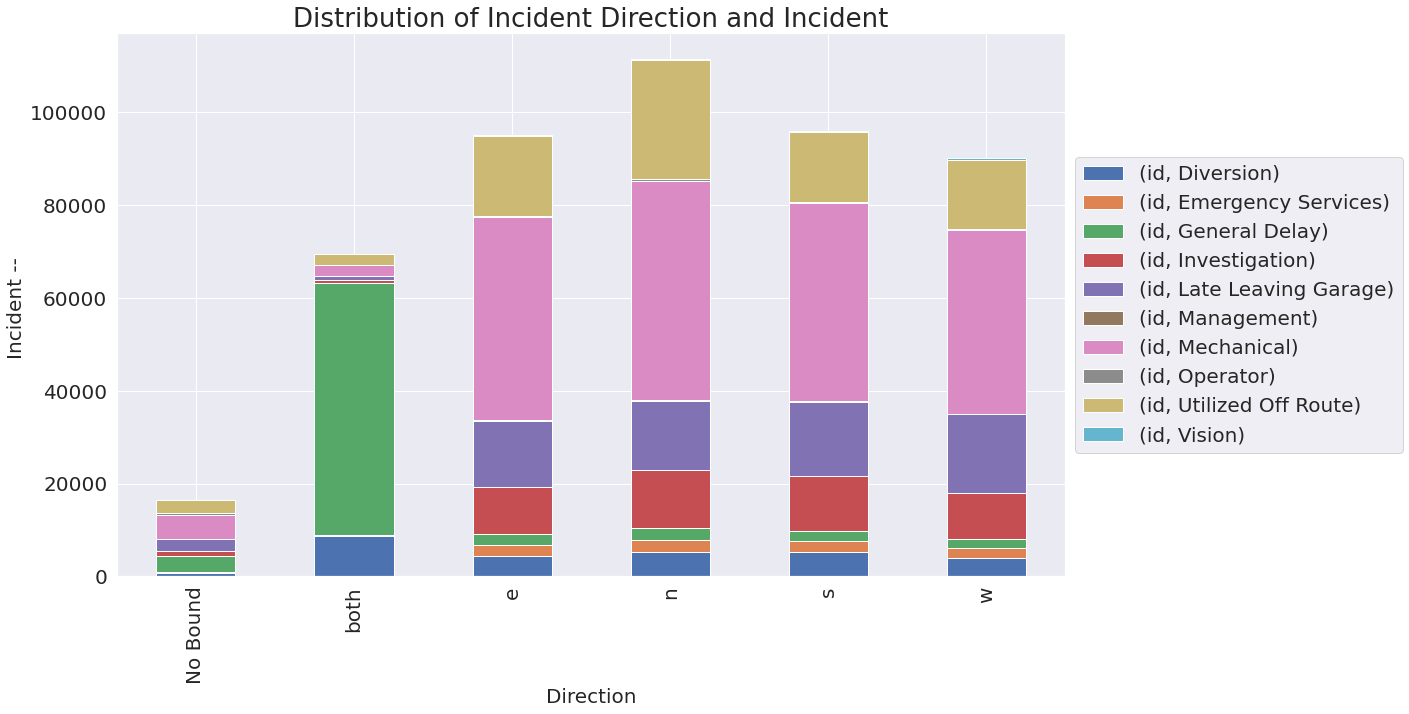

In [ ]:
# Use our custom-built function to slice and dice each variable pair
pivot = slice_and_dice(df, 'Direction', 'Incident', 'id')

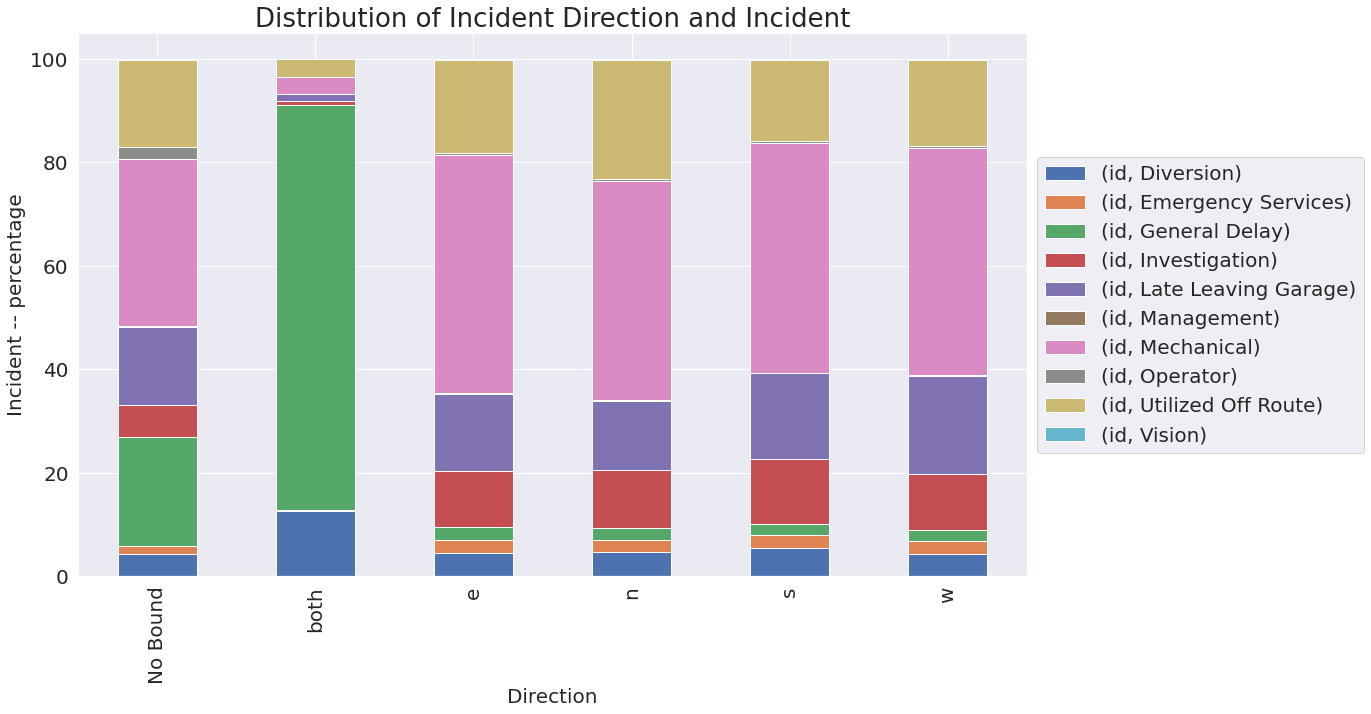

In [ ]:
pivot = slice_and_dice(df, 'Direction', 'Incident', 'id', norm=True)

<font color='midnightblue'>We find the reason for the strong association. While the N, S, E, W directions have similar distribution of Incident Type, "Both" and to some extent "No Bound" direction seems to be strong correlated with "General Delay". It will be interesting to figure out why this is the case (Unclear cause of delay?). Perhaps it's even warranted to remove records with "both" or "No Bound"</font>

### Incident Type vs Severity

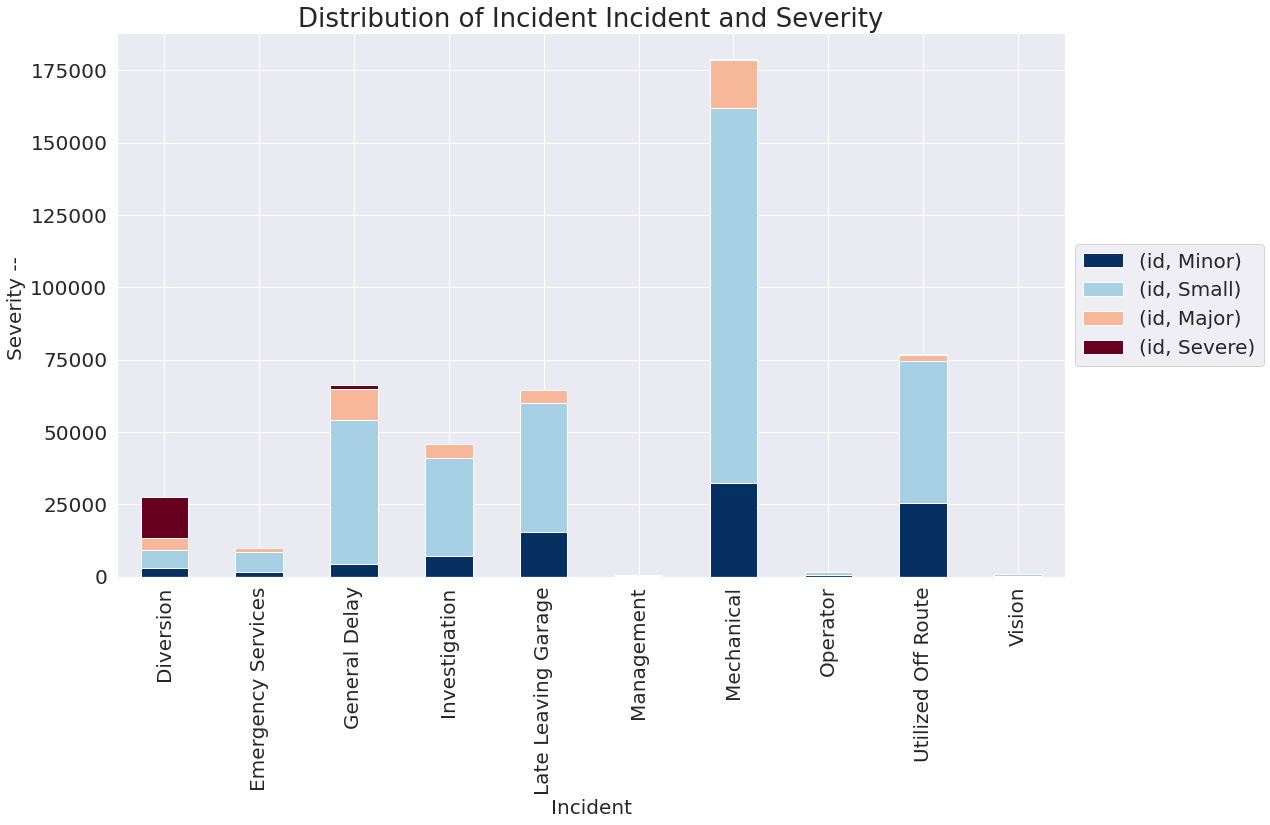

In [ ]:
# Use our custom-built function to slice and dice each variable pair. Set sequential color_scheme for severity
pivot = slice_and_dice(df, 'Incident', 'Severity', 'id', color_scheme='RdBu_r')

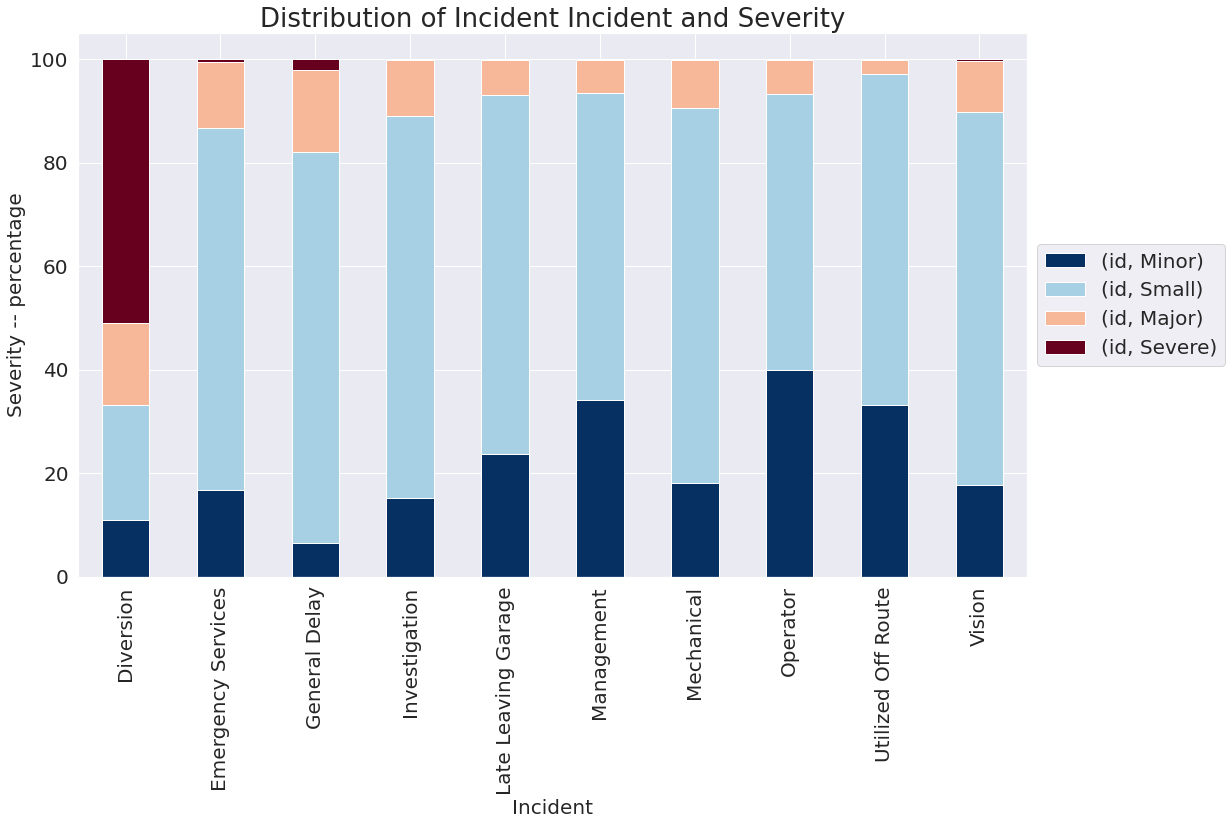

In [ ]:
pivot = slice_and_dice(df, 'Incident', 'Severity', 'id', norm=True, color_scheme='RdBu_r')

<font color='midnightblue'>We find a particular troublesome type of incident and those are caused by "Diversion" (Almost 70% of Diversion cause Major or Severe delays). Understanding how "Diversion" happens and what can be done to inform riders earlier about diversions may be able to improve the quality of Transit System. What about lower severity issues? Let's filter the dataset for "Small" or "Minor" delay with the same slice and dice.</font>

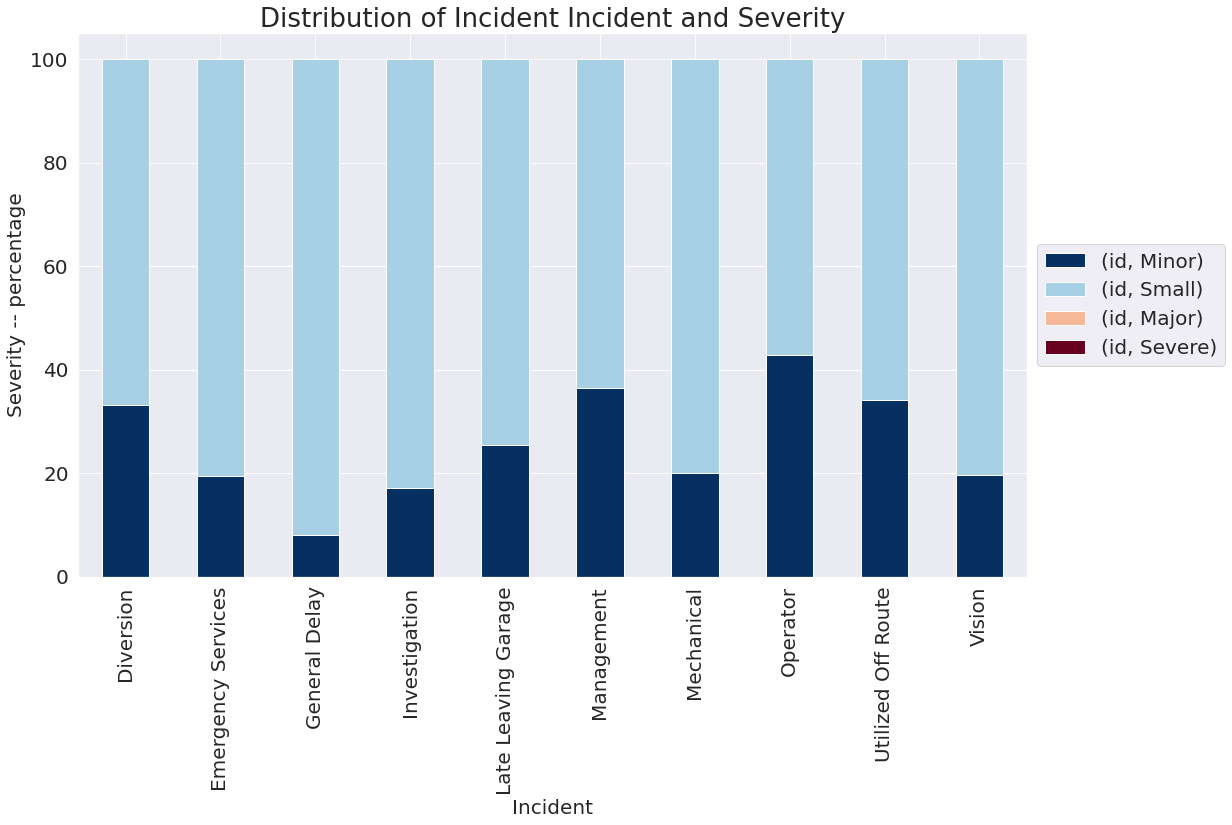

In [ ]:
pivot = slice_and_dice(df[df.Severity.isin(['Small', 'Minor'])], 'Incident', 'Severity', 'id', norm=True, color_scheme='RdBu_r')

<font color='midnightblue'>There is room to reduce the percentage of small delays into minor delays (to be barely noticeable by riders) when it comes to Mechanical issues, Emergency Services, Investigation and Vision. If somehow these activities can be scheduled during non-rush hour or forecasted beforehand, the quality of TTC will improve.</font>

### Hour of day by Incident type

<font color='midnightblue'>It's worth taking a look at some other variables (even without high association) to help us get an answer for the question put forth above. Here I will investigate the hour of the day vs Incident type to understand when do activities like Emergency Services, Investigation and Issues such as Mechanical and Vision happen.</font>

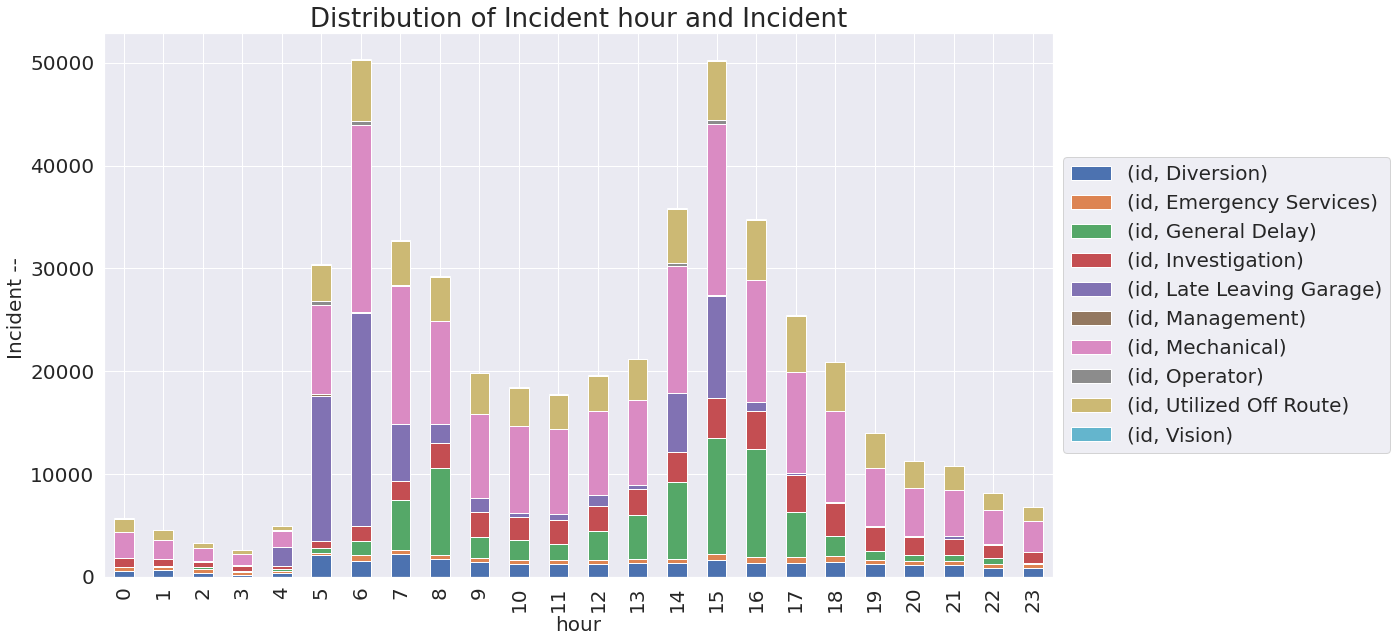

In [ ]:
pivot = slice_and_dice(df, 'hour', 'Incident', 'id')

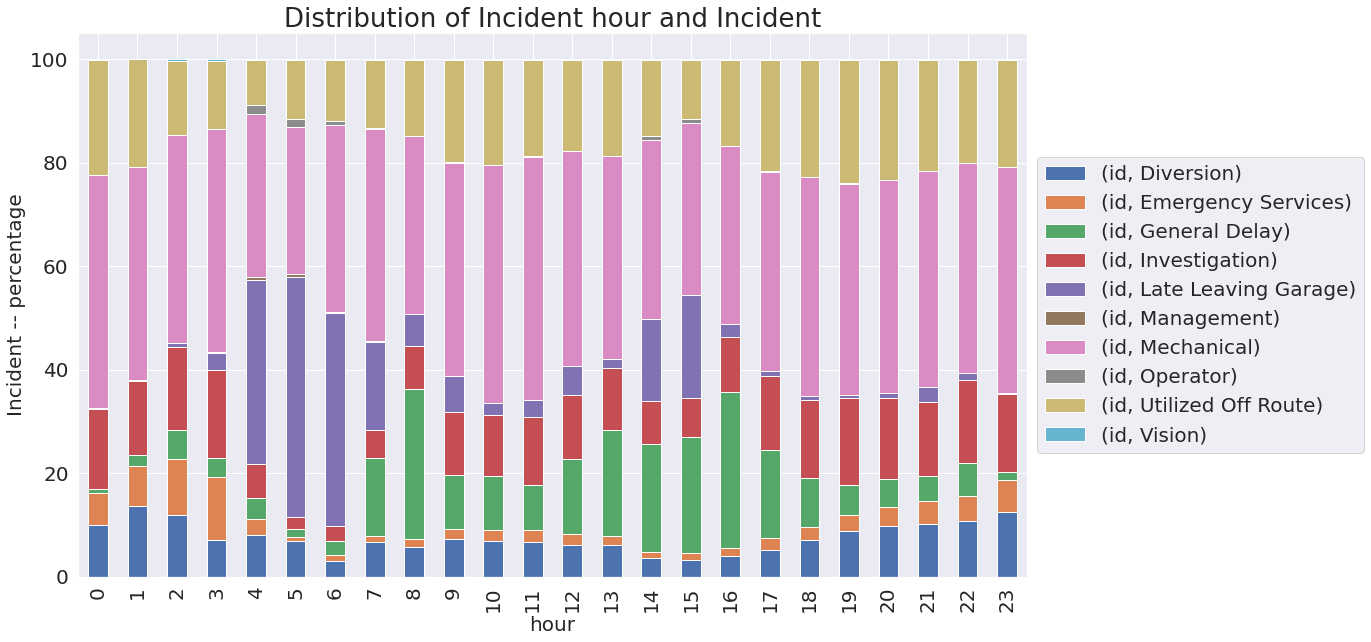

In [ ]:
pivot = slice_and_dice(df, 'hour', 'Incident', 'id', norm=True)

<font color='midnightblue'>A few learnings:
- Delays due to investigation don't happen proportionally a lot in rush hour (around 6 AM and 5 PM). This might mean that TTC has already made a conscious effort to avoid traffic hour for investigative events. 
- Delays due to diversion happens a lot during peak hours. This make sense as those hours require more coordination and more buses on the field.
- There are a lot of late leaving the garage in the morning. This could be due to human factor.</font>

### Hour of day by Severity

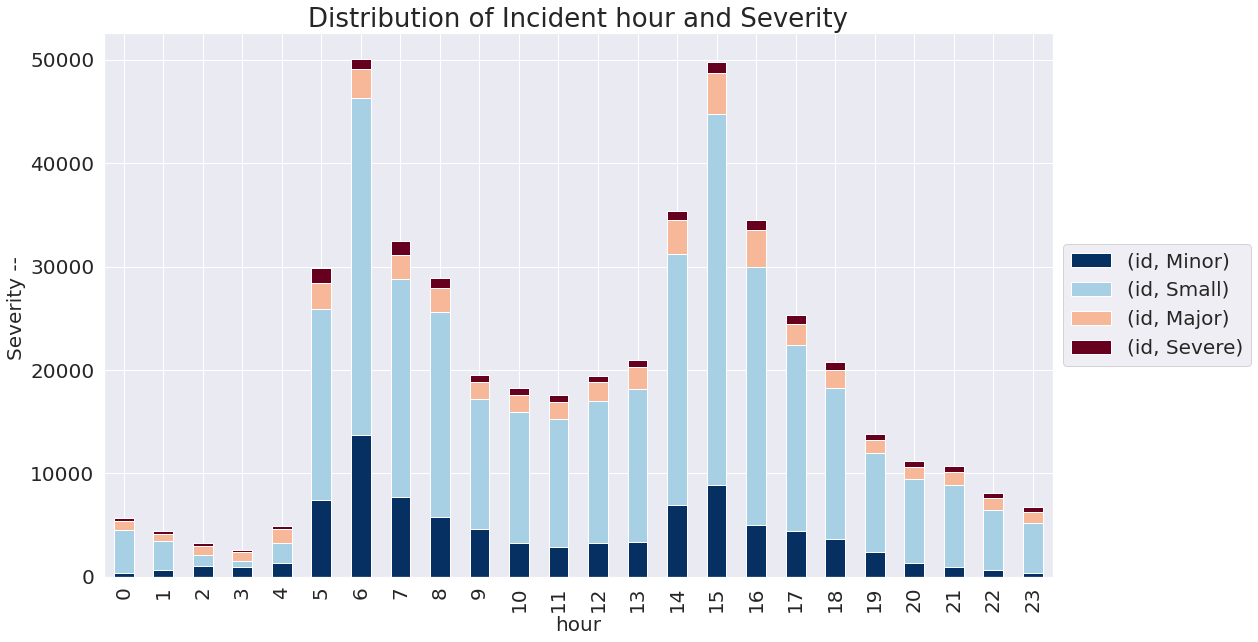

In [ ]:
pivot = slice_and_dice(df, 'hour', 'Severity', 'id', color_scheme='RdBu_r')

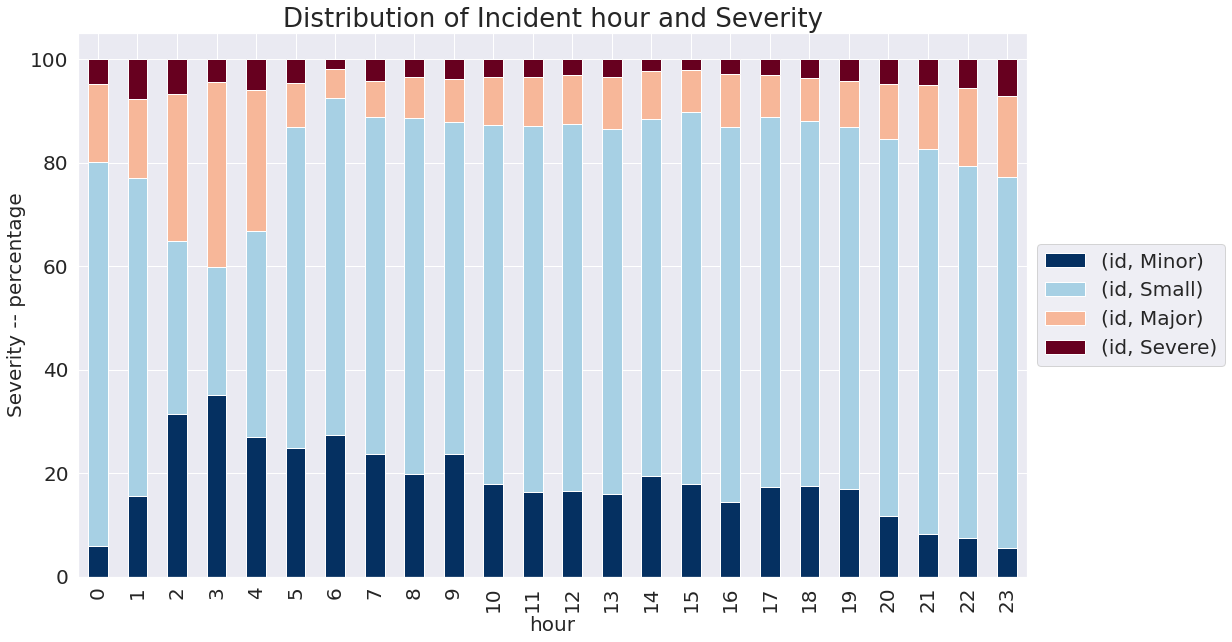

In [ ]:
pivot = slice_and_dice(df, 'hour', 'Severity', 'id', norm=True, color_scheme='RdBu_r')

<font color='midnightblue'>Interestingly, a large proportion of delay incidents (up to 40%) are routes which operate after 10 PM. to 4 AM. This could signify an issue with the unreliability of Night Buses. </font>

# "Messy" Data Analysis (UNFINISHED)

<font color='midnightblue'>If you recall, there are a few variables we haven't visited due to their complexity (Location, Route and Vehicle). Let's be thorough and see what kind of information can we learn from them. </font>

## Location

<font color='midnightblue'>In the "preprocessing.ipynb", we've utilized the power of string matching to automate some typo correction and location merging. </font>

In [ ]:
print(f'Original raw dataset had {len(df_bus.Location.unique())} unique locations')
print(f'String-matched dataset has {len(df_bus.Location_combined.unique())} unique locations')

Original raw dataset had 69633 unique locations
String-matched dataset has 8053 unique locations


In [ ]:
df_bus.Location_combined.value_counts().describe()

count     8052.000000
mean        59.434550
std        361.061932
min          1.000000
25%         10.000000
50%         16.000000
75%         32.000000
max      11909.000000
Name: Location_combined, dtype: float64

## Route

In [ ]:
df_bus.Route.value_counts()

29     13871
52     12181
32     11595
36     10488
54     10365
       ...  
966        1
222        1
837        1
221        1
170        1
Name: Route, Length: 448, dtype: int64

In [ ]:
df_bus.Route.value_counts().describe()

count      448.000000
mean      1070.098214
std       2181.013526
min          1.000000
25%          2.000000
50%         99.500000
75%        984.000000
max      13871.000000
Name: Route, dtype: float64

## Vehicle

In [ ]:
df_bus.Vehicle.value_counts()

0       70665
1         581
8304      352
1111      344
8167      304
        ...  
9613        1
7351        1
8223        1
27          1
8296        1
Name: Vehicle, Length: 3954, dtype: int64

In [ ]:
df_bus.Vehicle.value_counts().describe()

count     3954.000000
mean       121.245321
std       1125.483114
min          1.000000
25%         22.000000
50%         85.000000
75%        182.000000
max      70665.000000
Name: Vehicle, dtype: float64

# Conclusion & Use-case derivation

<font color='midnightblue'>In summary, the few important insights we got from EDA are:
- Delays have been happening less frequently over the years, but total delay time remain high due to the increasing number of routes and unchanged infrastructure. 
- 13% of delay incidents are problematic since they are delayed for above 40 minutes. In cases like these, those waiting for the bus might be justified in seeking alternative transportation.
- High severity delays appear disproportionately in a few features.</font>

<font color='midnightblue'> In lieu of this, the a simple use case for Machine Learning would be in supervised binary classification problem to classify for a bus user that given a delay is already happening, is the bus worth waiting for more OR should you try to find an alternative route?</font>

<font color='midnightblue'>We can modify our Severity feature to generate the label "wait", where 1 implies you should continue waiting and 0 means you should seek alternative transportation. We will define being worth waiting for means the bus will experience minor or small delay, whereas major and severe delay will imply seeking an alternative. </font>

<font color='midnightblue'> The features we will use for our classification are features which can be identified the moment of tardiness, namely, Route, Day, Location, Incident, Direction, Vehicle, year, month, dayofweek, hour.</font>

In [ ]:
df = df.drop(['id', 'Delay', 'Gap', 'datetime'], axis=1)
df['Location'] = df_bus['Location_combined']
df['Route'] = df_bus['Route']
df['Vehicle'] = df_bus['Vehicle']
df['Wait'] = [1 if severity in ['Small', 'Minor'] else 0 for severity in df.Severity]

In [ ]:
df.columns = [col.lower() for col in df.columns]

In [ ]:
df = df[df.vehicle != 0]

In [ ]:
df = df.dropna()

In [ ]:
df.to_csv(os.path.join(paths['final/bus'], 'bus.csv'))